# Lab 10: Performance Improvement

Congratulations! We've traveled very far along this Deep Learning journey together! We have learned about fully connected, convolutional and recurrent architectures and we applied them to a variety of problems, from image recognition to sentiment analysis.

One question we haven't answered yet is what to do when a model is not performing well. This is very common for Deep Learning models. We train a model and the performance on the test set is disappointing.

This issue could be due to many reasons:

* too little data
* wrong architecture
* too little training
* wrong hyper-parameters

How do we approach debugging and improving a model?

This lab is about a few techniques to do that. We will start by introducing **Learning Curves**, a tool that is useful to decide if more data is needed. Then we will present several **regularization** techniques, that may be useful to fight **Overfitting**. Some of these techniques have been invented very recently.

Finally, we will discuss **data augmentation**, which is useful in some cases, e.g., when the input data are images. We will conclude the lab with a brief part on **hyperparameter optimization**. This is a vast topic, that can be approached in several ways.

Let's start as usual with a few imports:

In [1]:
with open('common.py') as fin:
    exec(fin.read())

In [2]:
with open('matplotlibconf.py') as fin:
    exec(fin.read())

## Learning curves

The first tool we present is the [**Learning Curve**](https://en.wikipedia.org/wiki/Learning_curve). A learning curve plots the behavior of the training and validation scores as a function of how much training data we fed to the model.

Let's load a simple dataset and explore how to build a learning curve. We will use the digits dataset from Scikit Learn, which is quite small. First of all we import the `load_digits` function and use it:

In [3]:
from sklearn.datasets import load_digits

Now let's create a variable called `digits` we'll fill as the result of calling `load_digits()`:

In [4]:
digits = load_digits()

Then we assign `digits.data` and `digits.target` to `X` and `y` respectively:

In [5]:
X, y = digits.data, digits.target

Let's look at the shape of the `X` data:

In [6]:
X.shape

(1797, 64)

`X` is an array of 1797 images that have been unrolled as feature vectors of length 64.

In [7]:
y.shape

(1797,)

In order to see the images we can always reshape them to the original 8x8 format. Let's plot a few digits:

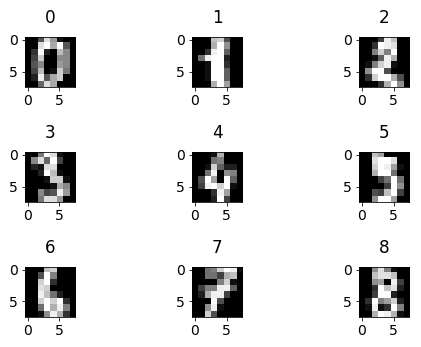

In [8]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X.reshape(-1, 8, 8)[i], cmap='gray')
    plt.title(y[i])
plt.tight_layout()

>TIP: the function `tight_layout` automatically adjusts subplot params so that the subplot(s) fits in to the figure area. See the [Documentation](https://matplotlib.org/users/tight_layout_guide.html) for further details.

Since `digits` is a Scikit Learn `Bunch` object, it has a property with the description of the data (in the `DESCR` key). Let's print it out:

In [9]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each bloc

From `digits.DESCR` we find that the input is made of integers in the range (0,16). Let's check that it's true by calculating the minimum and maximum values of X:

In [10]:
X.min()

0.0

In [11]:
X.max()

16.0

Let's also check the data type of `X`:

In [12]:
X.dtype

dtype('float64')

As previously seen in [Lab 3](3_Machine_Learning.ipynb#Feature-Transformations), it's a good practice to rescale the input so that it's close to 1. Let's do this by dividing by the maximum possible value (`16.0`):

In [13]:
X_sc = X / 16.0

`y` contains the labels as a list of digits:

In [14]:
y[:20]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Although it could appear that the digits are sorted, actually they are not:

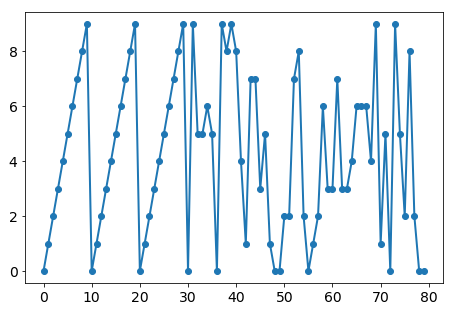

In [15]:
plt.plot(y[:80], 'o-');

As seen in [Lab 3](3_Machine_Learning.ipynb#Categorical-Features), let's convert them to 1-hot encoding, to substitute the categorical column with a set of boolean columns, one for each category. First, let's import the `to_categorical` method from `keras.utils`:

In [16]:
from tensorflow.keras.utils import to_categorical

Then let's set the variable of `y_cat` to these categories:

In [17]:
y_cat = to_categorical(y, 10)

Now we can split the data into a training and a test set. Let's import the `train_test_split` function and call it against our data and the target categories:

In [18]:
from sklearn.model_selection import train_test_split

We will split the data with a 70/30 ratio and we will use a `random_state` here, so that we all get the exact same train/test split. We will also use the option `stratify`, to require the ratio of classes be balanced, i.e. about 10% for each class (we already introduced this concept in [Lab 3](3_Machine_Learning.ipynb#Cross-Validation) for the _stratified K-fold_ cross validation).

In [19]:
X_train, X_test, y_train, y_test = \
    train_test_split(X_sc, y_cat, test_size=0.3,
                     random_state=0, stratify=y)

Let's double check that we have balanced the classes correctly. Since `y_test` is now a 1-hot encoded vector, we need first to recover the corresponding digits. We can do this using the function `argmax`:

In [20]:
y_test_classes = np.argmax(y_test, axis=1)

`y_test_classes` is an array of digits:

In [21]:
y_test_classes

array([1, 4, 5, 6, 9, 1, 2, 2, 2, 0, 7, 5, 4, 8, 6, 6, 8, 2, 0, 9, 7, 3,
       9, 1, 3, 5, 2, 2, 9, 9, 8, 9, 7, 6, 1, 3, 1, 4, 7, 6, 7, 3, 5, 0,
       1, 1, 7, 5, 4, 6, 0, 5, 8, 9, 0, 5, 4, 5, 3, 5, 5, 6, 5, 4, 9, 6,
       5, 9, 6, 5, 7, 6, 6, 3, 0, 8, 4, 4, 3, 2, 9, 7, 2, 7, 9, 8, 8, 0,
       1, 7, 2, 3, 3, 5, 5, 6, 0, 4, 3, 7, 1, 4, 1, 9, 0, 5, 3, 8, 9, 6,
       4, 9, 2, 9, 2, 0, 6, 7, 8, 1, 9, 2, 8, 6, 3, 6, 5, 1, 3, 6, 2, 3,
       0, 6, 5, 5, 9, 2, 8, 1, 0, 1, 4, 5, 1, 0, 3, 0, 0, 9, 8, 9, 2, 2,
       5, 8, 1, 9, 3, 7, 6, 8, 7, 3, 1, 2, 5, 1, 1, 6, 3, 9, 6, 9, 8, 9,
       9, 8, 9, 9, 8, 8, 4, 7, 6, 2, 6, 4, 3, 4, 4, 3, 8, 5, 4, 8, 3, 1,
       3, 4, 1, 0, 7, 8, 7, 5, 0, 6, 0, 1, 8, 7, 0, 0, 3, 4, 8, 9, 4, 4,
       1, 1, 2, 1, 9, 2, 7, 7, 6, 9, 2, 9, 6, 0, 5, 2, 4, 4, 4, 6, 4, 0,
       1, 8, 3, 4, 0, 5, 9, 0, 2, 0, 0, 1, 3, 2, 8, 1, 6, 1, 1, 9, 2, 7,
       8, 3, 8, 2, 1, 3, 3, 0, 7, 8, 6, 7, 1, 4, 8, 2, 1, 4, 2, 6, 0, 6,
       0, 1, 0, 8, 0, 6, 5, 1, 6, 6, 9, 2, 9, 2, 8,

There are many ways to count the number of each digit, the simplest is to temporarily wrap the array in a Pandas Series and use the `.value_counts()` method:

In [22]:
pd.Series(y_test_classes).value_counts()

5    55
3    55
1    55
9    54
7    54
6    54
4    54
0    54
2    53
8    52
dtype: int64

Great! Our classes are balanced, with around 54 samples per class. Let's quickly train a model to classify these digits. First we load the necessary libraries:

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

We create a small, fully connected network with 64 inputs, a single inner layer with 16 nodes and 10 outputs with a Softmax activation function:

In [24]:
model = Sequential()
model.add(Dense(16, input_shape=(64,),
                activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Let's also save the initial weights so that we can always re-start from the same initial configuration:

In [25]:
initial_weights = model.get_weights()

Now we fit the model on the training data for 100 epochs:

In [26]:
model.fit(X_train, y_train, epochs=100, verbose=0)

The model converged and we can evaluate the final training performance and test accuracies:

In [27]:
_, train_acc = model.evaluate(X_train, y_train,
                              verbose=0)
_, test_acc = model.evaluate(X_test, y_test,
                             verbose=0)

>TIP: The carachter `_` means that part of the function result can be deliberately ignored, and that variable can be throw away.                         

And print them out:

In [28]:
print("Train accuracy: {:0.4}".format(train_acc))
print("Test accuracy: {:0.4}".format(test_acc))

Train accuracy: 0.992
Test accuracy: 0.9741


The performance on the test set is lower than the performance on the training set, which indicates the model is _overfitting_.

> TIP: Overfitting is a fundamental concept in Machine Learning and Deep Learning. If you are not familiar with it, have a look at [Lab 3](3_Machine_Learning.ipynb#Train-/-Test-split).  

Before we start playing with different techniques to reduce overfitting, it is legitimate to ask if we don't have enough data to solve the problem.

_This is a very common situation_: you collect data with labels, you train a model, and the model does not perform as well as you hoped.

What should you do at that point? Should you collect more data? Alternatively, should you invest time in searching for better features or a different model?

With the little information we have, it is hard to know which of these alternatives is more likely to help. What is sure, on the other hand, is that all these alternatives carry a cost. For example, let's say you think that more data is what you need.

Collecting more labeled data could be as cheap and simple as downloading a new dataset from your source, or it could be as involved and complicated as coordinating with the data collection team at your company, hiring contractors to label the new data, and so on. In other words, the time and cost associated with new data collection strongly vary and need to be assessed case by case.

If, on the other hand, you decided to experiment with new features and model architectures, this could be as simple as adding a few layers and nodes to your model, or as complex as an R&D team dedicating several months to discovering new features for your particular dataset. Again, the actual cost of this option strongly depends on your specific use case.

Which of the two choices is more promising?

![Do we need more data or a better model?](./assets/more_data_better_model.png)

A learning curve is a tool we can use to answer that question. Here is how we build it.

First, we set the `X_test` aside, then, we take increasingly large fractions of `X_train` and use them to train the model. For each of these fractions, we fit the model. Then we evaluate the model on this fraction and the test set.
Since the training data is small, we expect the model to overfit the training data and perform quite poorly on the test set.

As we gradually take more training data, the model should improve and learn to generalize better, i.e., the test score should increase. We proceed like this until we have used all our training data.

At this point two cases are possible. If it looks like the test performance stopped increasing with the size of the training set, we probably reached the maximum performance of our model. In this case, we should invest time in looking for a better model to improve our performance.

In the second case, it would seem that the test error would continue to decrease if only we had access to more training data. If that's the case, we should probably go out looking for more labeled data first and then worry about changing model.

So, now you know how to answer the big question of more data or better model: _use a learning curve_.

Let's draw one together. First, we take increasing fractions of the training data using the function `np.linspace`.

> TIP: `np.linspace` returns evenly spaced numbers over a specified interval. In this case, we are creating four fractions, from 10% to 90% of the data.

In [29]:
fracs = np.linspace(0.1, 0.90, 5)
fracs

array([0.1, 0.3, 0.5, 0.7, 0.9])

In [30]:
train_sizes = list((len(X_train) * fracs).astype(int))
train_sizes

[125, 377, 628, 879, 1131]

Then we loop over the train sizes, and for each `train_size` we do the following:

- take exactly `train_size` data from the `X_train`
- reset the model to the initial weights
- train the model using only the fraction of training data
- evaluate the model on the fraction of training data
- evaluate the model on the test data
- append both scores to arrays for plotting

Handling this in the first case (i.e., the first `train_size` in our `train_sizes` array), we'll use our work to then iterate over a long list of all the `train_sizes`.

Let's create some variables where we'll store our scores:

In [31]:
train_scores = []
test_scores = []

Now let's break up the test data using the `train_test_split` function as we usually would:

In [32]:
X_train_frac, _, y_train_frac, _ = \
    train_test_split(X_train, y_train,
                     train_size=0.1, 
                     test_size=None,
                     random_state=0, 
                     stratify=y_train)

Let's reset the weights to their initial values:

In [33]:
model.set_weights(initial_weights)

Now we can train our model using the `fit` function, as normal:

In [34]:
h = model.fit(X_train_frac, y_train_frac,
              verbose=0,
              epochs=100)

With our model trained, let's evaluate it over our training set and save it into the `train_scores` variable from above:

In [35]:
r = model.evaluate(X_train_frac, y_train_frac,
                   verbose=0)
train_scores.append(r[-1])

Let's do the same with our test set:

In [36]:
e = model.evaluate(X_test, y_test, verbose=0)
test_scores.append(e[-1])

It's kind of silly to do this manually for every `train_size` entry. Instead, let's iterate over them and build up our `train_scores` and `test_scores` variables:

In [37]:
train_scores = []
test_scores = []

for train_size in train_sizes:
    X_train_frac, _, y_train_frac, _ = \
    train_test_split(X_train, y_train,
                     train_size=train_size,
                     test_size=None,
                     random_state=0,
                     stratify=y_train)
    
    model.set_weights(initial_weights)
    
    h = model.fit(X_train_frac, y_train_frac,
                  verbose=0,
                  epochs=100)

    r = model.evaluate(X_train_frac, y_train_frac,
                       verbose=0)
    train_scores.append(r[-1])
    
    e = model.evaluate(X_test, y_test, verbose=0)
    test_scores.append(e[-1])
    
    print("Done size: ", train_size)

Done size:  125
Done size:  377
Done size:  628
Done size:  879
Done size:  1131


Let's plot the training score and the test score as a function of increasing training size:

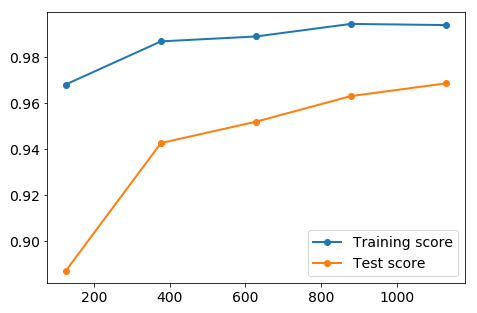

In [38]:
plt.plot(train_sizes, train_scores, 'o-', label="Training score")
plt.plot(train_sizes, test_scores, 'o-', label="Test score")
plt.legend(loc="best");

Judging from the curve, it appears the test score would keep improving if we added more data. This is the indication we were looking for. If on the other hand the test score was not improving, it would have been more promising to improve the model first and only then go look for more data if needed.

## Reducing Overfitting

Sometimes it's not easy to go out and look for more data. It could be time consuming and expensive. There are a few ways to improve a model and reduce its propensity to overfit without requiring additional data. These fall into the big family of **Regularization techniques**.

The general idea here is the following. By now you should understand that the complexity of a model is somewhat represented by the number of parameters the model has. In simple terms, a model with many layers and many nodes is more complex than a model with a single layer and few nodes. More complexity gives the model, more freedom to learn nuances in our training data. This is what makes Neural Networks so powerful.

On the other hand, the more freedom a model has, the more likely it will be to overfit on the training data, losing the ability to generalize. We could try to reduce the model freedom by reducing the model complexity, but this would not always be a great idea as it would make the model less able to pick up subtle patterns in our data.

A different approach would be to keep the model very complex, but change something else in the model to push it towards less complex solutions. In other words, instead of removing the complexity, we allow the model to choose complex solutions, but we drive the model towards simpler, more _regular_, solutions. Regularization refers to techniques to keep the complexity of a model from spinning out of control.

Let's review a few ways to regularize a model, and to ease our comparison we will define a few helper functions.

First, let's define a helper function to repeat the training several times. This helper function will be useful to average out any statistical fluctuations in the model behavior due to the random initialization of the weights. We will reset the backend at each iteration to save memory and erase any previous training.

Let's load the backend first:

In [39]:
import tensorflow.keras.backend as K

And then let's define the `repeat_train` helper function. This function expects an already created `model_fn` as input, i.e. a function that returns a model, and it repeats the following process a number of times specified by the input `repeats`:

1. clear the session
```python
K.clear_session()
```
- create a model using the `model_fn`
```python
model = model_fn()
```
- train the model using the training data
```python
h = model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              verbose=verbose,
              batch_size=batch_size,
              epochs=epochs)
```
- retrieve the accuracy of the model on training data (`acc`) and test data (`val_acc`) and append the results to the `histories` array
```python
histories.append([h.history['accuracy'], h.history['val_accuracy']])
```

Finally, the `repeat_train` function calculates the average history along with its standard deviation and returns them.

In [40]:
def repeat_train(model_fn, repeats=3, epochs=40,
                 verbose=0, batch_size=256):
    """
    Repeatedly train a model on (X_train, y_train),
    averaging the histories.
    
    Parameters
    ----------
    model_fn : a function with no parameters
        Function that returns a Keras model

    repeats : int, (default=3)
        Number of times the training is repeated
    
    epochs : int, (default=40)
        Number of epochs for each training run
    
    verbose : int, (default=0)
        Verbose option for the `model.fit` function
    
    batch_size : int, (default=256)
        Batch size for the `model.fit` function
        
    Returns
    -------
    mean, std : np.array, shape: (epochs, 2)
        mean : array contains the accuracy
        and validation accuracy history averaged
        over the different training runs
        std : array contains the standard deviation
        over the different training runs of
        accuracy and validation accuracy history
    """
    histories = []
    
    # repeat model definition and training
    for repeat in range(repeats):
        K.clear_session()
        model = model_fn()
        
        # train model on training data
        h = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      verbose=verbose,
                      batch_size=batch_size,
                      epochs=epochs)
        
        # append accuracy and val accuracy to list
        histories.append([h.history['accuracy'],
                          h.history['val_accuracy']])
        print(repeat, end=" ")
        
    histories = np.array(histories)
    print()
    
    # calculate mean and std across repeats:
    mean = histories.mean(axis=0)
    std = histories.std(axis=0)
    return mean, std

The `repeat_train` function expects an already created `model_fn` as input. Hence, let's define a new function that will create a fully connected Neural Network with 3 inner layers. We'll call this function `base_model`, since we will use this basic model for further comparison:

In [41]:
def base_model():
    """
    Return a fully connected model with 3 inner layers
    with 1024 nodes each and relu activation function
    """
    model = Sequential()
    model.add(Dense(1024, input_shape=(64,),
                    activation='relu'))
    model.add(Dense(1024,
                    activation='relu'))
    model.add(Dense(1024,
                    activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile('adam', 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

>TIP: Notice that this model is quite big for the problem we are trying to solve. We purposefully make the model big, so that there are lots of parameters and it can overfit easily.

Now we repeat 5 times the training of the base (non-regularized) model using the `repeat_train` helper function:

In [42]:
((m_train_base, m_test_base),
 (s_train_base, s_test_base)) = \
    repeat_train(base_model, repeats=5)

0 1 2 3 4 


We can plot the histories for training and test. First, let's define an additional helper function `plot_mean_std()`,    which plots the average history as a line and add a colored area around it corresponding to +/- 1 standard deviation:

In [43]:
def plot_mean_std(m, s):
    """
    Plot the average history as a line
    and add a colored area around it corresponding
    to +/- 1 standard deviation
    """
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.2)

Then, let's plot the results obtained training 5 times the base model:

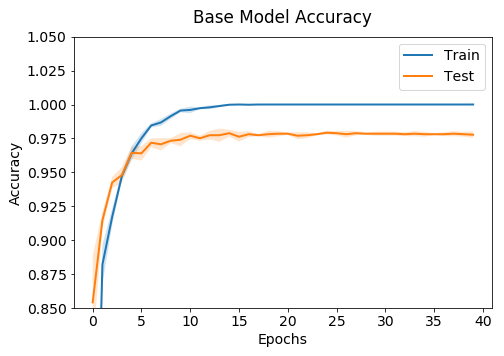

In [44]:
plot_mean_std(m_train_base, s_train_base)
plot_mean_std(m_test_base, s_test_base)

plt.title("Base Model Accuracy")
plt.legend(['Train', 'Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.05);

Overfitting in this case is evident, with the test score saturating at a lower value than the training score.

### Model Regularization

[Regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics%29) is a common procedure in Machine Learning and it has been used to improve the performance of complex models with many parameters.

Remember the [Cost Function](https://en.wikipedia.org/wiki/Loss_function) we have introduced in [Lab 3](./03_Machine_Learning.ipynb#Cost-function)? The main goal of the cost function is to make sure that the predictions of the model are close to the correct labels.

Regularization works by modifying the original cost function $C$ with an additional term $\lambda C_r$, that somehow penalizes the complexity of the model:

\begin{equation}
C' = C + \lambda C_r
\end{equation}

The original cost function $C$ would decrease as the model predictions got closer and closer to the actual labels. In other words, the gradient descent algorithm for the original cost would push the parameters to the region of parameter space that would give the best predictions on the training data. In complex models with many parameters, this could result in overfitting because of all the freedom the model had.

The new penalty $C_r$ pushes the model to be "simple", in other words, it grows with the parameters of the model, but it is entirely unrelated to the goodness of the prediction.

![Weight Regularization](./assets/regularization.png)

The total cost $C'$ is a combination of the two terms, and therefore the model will have to try to generate the best predictions possible while retaining simplicity. In other words, the gradient descent algorithm is now solving a constrained minimization problem, where some regions of the parameter space are too expensive to use for a solution.

The hyper-parameter $\lambda$ determines the relative strength of the regularization, and we can set it.

But how do we implement $C_r$ in practice? There are several ways to do it. **Weight Regularization** assigns a penalty proportional to the size of the weights, for example:

\begin{equation}
C_w = \sum_w |w|
\end{equation}
or:
\begin{equation}
C_w = \sum_w w^2
\end{equation}

The first one is called **l1-regularization** and it is the sum of the absolute values of each weight. The second one is called **l2-regularization** and it is the sum of the square values of each weight. While they both suppress complexity, their effect is different.

l1-regularization pushes most weights to be zero, except for a few that will be non-zero. In other words, the net effect of l1-regularization is to make the weight matrix _sparse_.

l2-regularization, on the other hand, suppresses weights quadratically, which means that any weight more significant than the others will give a much higher contribution to $C_r$ and therefore to the overall cost. The net effect of this is to make all weights equally small.

Similarly to weight regularization, **Bias Regularization** and **Activity Regularization** penalize the cost function with a term proportional to the size of the biases and the activations respectively.

Let's compare the behavior of our base model with a model with exact the same architecture but endowed with the `l2` weight regularization.

We start by defining a helper function that creates a model with weight regularization: we start from the function `base_model`, and we create the function `regularized_model`, adding the `kernel_regularizer` option to each layer. First of all let's import keras's `l2` regularizer function:

In [45]:
from tensorflow.keras.regularizers import l2

In [46]:
def regularized_model():
    """
    Return an l2-weight-regularized, fully connected
    model with 3 inner layers with 1024 nodes each
    and relu activation function.
    """
    reg = l2(0.005)
    
    model = Sequential()
    model.add(Dense(1024,
                    input_shape=(64,),
                    activation='relu',
                    kernel_regularizer=reg))
    model.add(Dense(1024,
                    activation='relu',
                    kernel_regularizer=reg))
    model.add(Dense(1024,
                    activation='relu',
                    kernel_regularizer=reg))
    model.add(Dense(10, activation='softmax'))
    model.compile('adam', 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Now we compare the results of no regularization and l2-regularization. Let's repeat the training 3 times.

In [47]:
(m_train_reg, m_test_reg), (s_train_reg, s_test_reg) = \
    repeat_train(regularized_model)

0 1 2 


>TIP: Notice that, since we didn't specified the number of time to train the model, it will repeat the training according to the default parameter, i.e. 3 times.

Let's now compare the performance of the weight regularized model with our base model. We will also plot a dashed line at the maximum test accuracy obtained by the base model:

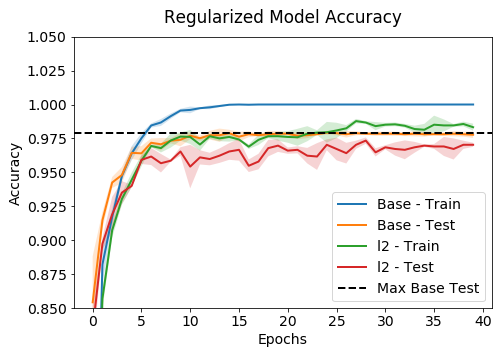

In [48]:
plot_mean_std(m_train_base, s_train_base)
plot_mean_std(m_test_base, s_test_base)

plot_mean_std(m_train_reg, s_train_reg)
plot_mean_std(m_test_reg, s_test_reg)

plt.axhline(m_test_base.max(),
            linestyle='dashed',
            color='black')

plt.title("Regularized Model Accuracy")
plt.legend(['Base - Train', 'Base - Test',
            'l2 - Train', 'l2 - Test',
            'Max Base Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.05);

With this particular dataset, weight regularization does not seem to improve the model performance.

This is visually true at least within the small number of epochs we are running. It may be the case that if we let the training run much longer regularization would help, but we don't know for sure, and that can cost a lot of time and money.

It's however good to know that this technique exists and keep it in mind as one of the options to try. In practice, weight regularization has been replaced by more modern regularization techniques such as **Dropout** and **Batch Normalization**.

### Dropout

[Dropout](https://en.wikipedia.org/wiki/Dropout_(neural_networks%29) was introduced in 2014 by [Srivastava et al.](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf) at the University of Toronto to address the problem of overfitting in large networks. The key idea of Dropout is to randomly drop units (along with their connections) from the Neural Network during training.

![Dropout](./assets/dropout_network.png)

In other words, during the training phase, each unit has a non-zero probability not to emit its output to the next layer. This prevents units from co-adapting too much.

Let's reflect on this for a second. It looks as if we are damaging the network by dropping a fraction of the units with non zero probability during training time. We are crippling the network and making it a lot harder for it to learn. This is counter-intuitive! Why are we weakening our model?

It turns out that the underlying principle is quite universal in Machine Learning: we make the network less stable so that the solution found during training is more general, more robust, and more resilient to failure. Another way to look at this is to say that we are adding noise at training time so that the network will need to learn more general patterns that are resistant to noise.

The technique has similarities with ensemble techniques, because it's as if, during training the network sampled from an many different “thinned” networks, where a few of the nodes are not working. At test time, dropout is turned off, and we use the full network. This technique has been shown to improve the performance of Neural Networks on Supervised Learning tasks in vision, speech recognition, document classification, and many others.

We strongly encourage you to read the [paper](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf) if you want to understand how dropout is implemented.

On the other hand, if you are eager to apply it, you'll be happy to hear that Dropout is implemented in Keras as a layer, so all we need to do is to add it between the layers. We'll import it first:

In [49]:
from tensorflow.keras.layers import Dropout

And then we define a `dropout_model`, again starting from the `base_model` and adding the dropout layers. We've tested several configurations, and we've found that with this dataset good results can be obtained with a dropout rate of 10% at the input and 50% in the inner layers. Feel free to experiment with different numbers and see what results you get.

>TIP: according to the [Documentation](https://keras.io/layers/core/#dropout), in the `Dropout` layer
the argument `rate` is a float between 0 and 1, that gives the fraction of the input units to drop.

In [50]:
def dropout_model():
    """
    Return a fully connected model
    with 3 inner layers with 1024 nodes each
    and relu activation function. Dropout can
    be applied by selecting the rate of dropout
    """
    input_rate = 0.1
    rate = 0.5

    model = Sequential()
    model.add(Dropout(input_rate, input_shape=(64,)))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(rate))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(rate))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(rate))
    model.add(Dense(10, activation='softmax'))
    model.compile('adam', 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Let's train three times our network using the `dropout_model`:

In [51]:
(m_train_dro, m_test_dro), (s_train_dro, s_test_dro) = \
    repeat_train(dropout_model)

0 1 2 


Next, let's plot the accuracy of the dropout model against the base model:

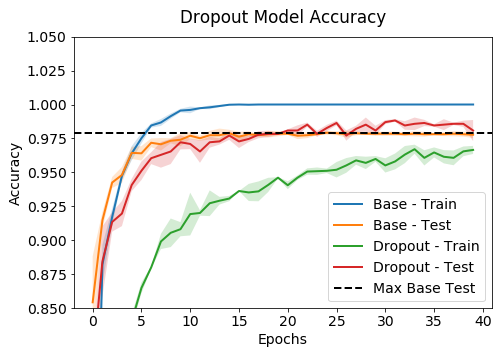

In [52]:
plot_mean_std(m_train_base, s_train_base)
plot_mean_std(m_test_base, s_test_base)

plot_mean_std(m_train_dro, s_train_dro)
plot_mean_std(m_test_dro, s_test_dro)

plt.axhline(m_test_base.max(),
            linestyle='dashed',
            color='black')

plt.title("Dropout Model Accuracy")
plt.legend(['Base - Train', 'Base - Test',
            'Dropout - Train', 'Dropout - Test',
            'Max Base Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.05);

Nice! Adding Dropout to our model pushed our test score above the base model for the first time (although not by much)! This is great because we didn't have to add more data. Also, notice how the training score is lower than the test score, which indicates the model is not overfitting and also there seem to be even more room for improvement if we run the training for more epochs!

The Dropout paper also mentions the use of a global constraint to improve the behavior of a Dropout network further. Constraints can be added in Keras through the `kernel_constraint` parameter available in the definition of a layer.
Following the paper, let's see what happens if we impose a `max_norm` constraint to the weights of the model. According to the [Documentation](https://keras.io/constraints/), this is equivalent to say that the sum of the square of the weights cannot be higher than a certain _constant_, which can be specified by the user with the argument `c`.

Let's load the `max_norm` constraint first:

In [53]:
from tensorflow.keras.constraints import max_norm

Let's define a new model function `dropout_max_norm`, that has both `dropout` and the `max_norm` constraint:

In [54]:
def dropout_max_norm():
    """
    Return a fully connected model with Dropout
    and Max Norm constraint.
    """
    input_rate = 0.1
    rate = 0.5
    c = 2.0
    
    model = Sequential()
    model.add(Dropout(input_rate, input_shape=(64,)))
    model.add(Dense(1024, activation='relu',
                    kernel_constraint=max_norm(c)))
    model.add(Dropout(rate))
    model.add(Dense(1024, activation='relu',
                    kernel_constraint=max_norm(c)))
    model.add(Dropout(rate))
    model.add(Dense(1024, activation='relu',
                    kernel_constraint=max_norm(c)))
    model.add(Dropout(rate))
    model.add(Dense(10, activation='softmax'))
    model.compile('adam', 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

As before, we repeat the training three times and average the results:

In [55]:
(m_train_dmn, m_test_dmn), (s_train_dmn, s_test_dmn) = \
    repeat_train(dropout_max_norm)

0 1 2 


and plot the comparison with the base model:

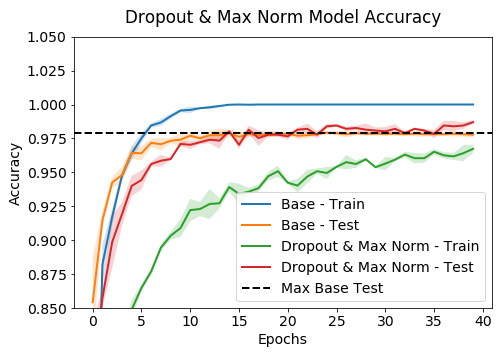

In [56]:
plot_mean_std(m_train_base, s_train_base)
plot_mean_std(m_test_base, s_test_base)

plot_mean_std(m_train_dmn, s_train_dmn)
plot_mean_std(m_test_dmn, s_test_dmn)

plt.axhline(m_test_base.max(),
            linestyle='dashed',
            color='black')

plt.title("Dropout & Max Norm Model Accuracy")
plt.legend(['Base - Train', 'Base - Test',
            'Dropout & Max Norm - Train', 'Dropout & Max Norm - Test',
            'Max Base Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.05);

In this particular case, the Max Norm constraint does not seem to produce results that are qualitatively different from the simple Dropout, but there may be datasets where this constraint helps make the network converge to a better result.

### Batch Normalization

_Batch Normalization_ was introduced in 2015 as an even better regularization technique, as described in this [paper](https://arxiv.org/pdf/1502.03167.pdf). The authors of the paper started from the observation that training of deep Neural Networks is slow because the distribution of the inputs to a layer changes during training, as the parameters of the previous layers change. Since the inputs to a layer are the outputs of the previous layer, and these are determined by the parameters of the previous layer, as training proceeds the distribution of the output may drift, making it harder for the next layer to adapt.

The authors' solution to this problem is to introduce a normalization step between layers, that will take the output values for the current batch and normalize them by removing the mean and dividing by the standard deviation. They observe that their technique allows to use much higher learning rates and be less careful about initialization. It also acts as a regularizer, in some cases eliminating the need for Dropout.

Let's walk through the batch algorithm with a small code example. First we calculate the mean and standard deviation of the batch:
```python
mu_B = X_batch.mean()
std_B = X_batch.std()
```
Then we subtract the mean and divide by the standard deviation:
```python
X_batch_scaled = (X_batch - mu_B) / np.sqrt(std_B**2 + 0.0001)
```
Finally we rescale the batch with 2 parameters $\gamma$ and $\beta$ that are learned during training:
```python
X_batch_norm = gamma * X_batch_rescaled + beta
```
> TIP: Using math notation, the complete algorithm for Batch normalization is the following. Given a mini-batch $B = \{x_{1...m}\}$
>
\begin{align}
\mu_B &= \frac{1}{m} \sum_{i=1}^{m} x_i \\
\sigma_B &= \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2 \\
\hat{x_i} &= \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}} \\
y_i &= \gamma \hat{x_i} + \beta \\
\end{align}




Batch Normalization is very powerful, and Keras makes it available as a layer too, as described in the [Documentation](https://keras.io/layers/normalization/). One important thing to note is that BN needs to be applied before the nonlinear activation function. Let's see how it's done. First we load the `BatchNormalization` and `Activation` layers:

In [57]:
from tensorflow.keras.layers import BatchNormalization, Activation

Then we define again a new model function `batch_norm_model` that adds Batch Normalization to our fully connected network defined in the `base_model`:

In [58]:
def batch_norm_model():
    """
    Return a fully connected model with
    Batch Normalization.

    Returns
    -------
    model : a compiled keras model
    """
    model = Sequential()
    
    model.add(Dense(1024, input_shape=(64,)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(10))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    model.compile('adam', 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Batch Normalization seems to work better with smaller batches, so we will run the `repeat_train` function with a smaller `batch_size`.

Since smaller batches mean more weight updates at each epoch, we will also run the training for fewer epochs.

Let's do a quick back of the envelope calculation.

We have 1257 points in the training set. Previously, we used batches of 256 points, which gives five weight updates per epoch, and a total of 200 updates in 40 epochs. If we reduce the batch size to 32, we will have 40 updates at each epoch, so we should run the training for only five epochs.

We will run it a bit longer to see the effectiveness of Batch Normalization. 10-15 epochs will suffice to bring the model accuracy to a much higher value on the test set.

In [59]:
(m_train_bn, m_test_bn), (s_train_bn, s_test_bn) = \
    repeat_train(batch_norm_model,
                 batch_size=32,
                 epochs=15)

0 1 2 


Let's plot the results and compare them with the base model:

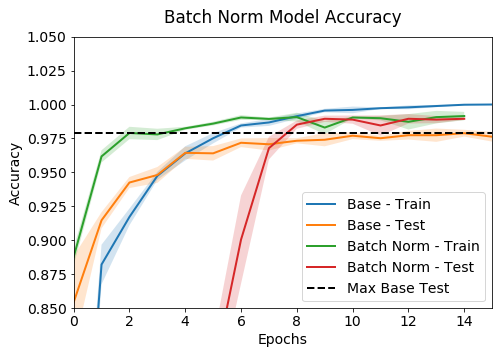

In [60]:
plot_mean_std(m_train_base, s_train_base)
plot_mean_std(m_test_base, s_test_base)

plot_mean_std(m_train_bn, s_train_bn)
plot_mean_std(m_test_bn, s_test_bn)

plt.axhline(m_test_base.max(),
            linestyle='dashed',
            color='black')

plt.title("Batch Norm Model Accuracy")
plt.legend(['Base - Train', 'Base - Test',
            'Batch Norm - Train', 'Batch Norm - Test',
            'Max Base Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.05)
plt.xlim(0, 15);

Awesome! With the addition of Batch Normalization, the model converged to a solution that is better able to generalize on the Test set, i.e., it is overfitting a lot less than the base solution.

## Data augmentation

Another strong technique to improve the performance of a model without requiring the collection of new data is **Data Augmentation**. Let's consider the problem of image recognition, and to make things practical, let's consider this nice picture of a squirrel:

![Image of a squirrel](./assets/squirrel.jpeg)

If your goal were to recognize the animal in this picture, you would still be able to solve the task effectively even if we distorted the image or rotated it. There's a variety of transformations that we could apply to the image, without altering its information content, including:

- rotation
- shift (up, down, left, right)
- shear
- zoom
- flip (vertical, horizontal)
- rescale
- color correction and changes
- partial occlusion

All these transformations would not destroy the information contained in the image. They would change the absolute values of the pixels. A human would still be able to recognize a rotated squirrel or a shifted panda, very much as you can still recognize your friends even after all the filters they apply to their selfies. This property means a good image recognition algorithm should also be resilient to this kind of transformations.

If we apply these transformations to an image in our training dataset, we can generate an infinite number of variations of such image, giving us access to a much much larger synthetic training dataset. This process is what data augmentation is about: generating new labeled data points starting from existing data through the use of valid transformations.

Although the example we provided is in the domain of image recognition, the same process can be applied to augment other kinds of data, for example, speech samples for a speech recognition task. Given a particular sound file, we can change its speed and pitch, add background noise, add silences to generate variations of the speech snippet that would still be correctly understood by a human.

Let's see how Keras allows us to do it easily for images. We need to load the [`ImageDataGenerator`](https://keras.io/preprocessing/image/) object:

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

This class creates a generator that can apply all sorts of variations to an input image. Let's initialize it with a few parameters:
- We'll set the `rescale` factor to `1/255` to normalize pixel values to the interval [0-1]
- We'll set the `width_shift_range` and `height_shift_range` to ±10% of the total range
- We'll set the `rotation_range` to ±20 degrees
- We'll set the `shear_range` to ±0.3 degrees
- We'll set the `zoom_range` to ±30%
- We'll allow for `horizontal_flip` of the image

See the [Documentation](https://keras.io/preprocessing/image/) for a complete overview of all the available arguments.

In [62]:
idg = ImageDataGenerator(rescale = 1./255,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         rotation_range = 20,
                         shear_range = 0.3,
                         zoom_range = 0.3,
                         horizontal_flip = True)

The next step is to create an iterator that will generate images with the image data generator. We need to tell where our training data are. Here we use the method `flow_from_directory`, which is useful when we have images stored in a directory, and we tell it to produce target images of size 128x128. The input folder structure needs to be:

    top/
        class_0/
        class_1/
        ...

Where `top` is the folder we will flow from, and the images are organized into one subfolder for each class.

In [63]:
train_gen = idg.flow_from_directory(
    '../data/generator',
    target_size = (128, 128),
    class_mode = 'binary')

Found 1 images belonging to 1 classes.


Let's generate a few images and display them:

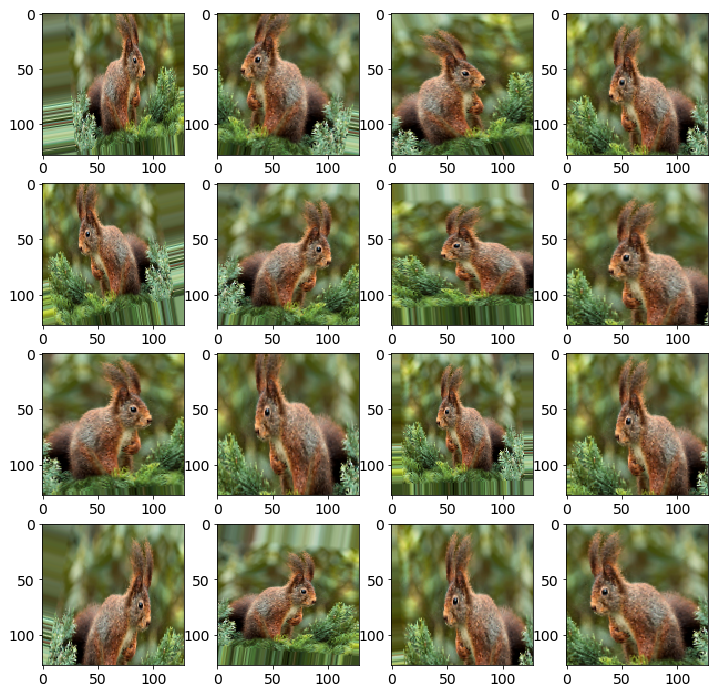

In [64]:
plt.figure(figsize=(12, 12))

for i in range(16):
    img, label = train_gen.next()
    plt.subplot(4, 4, i+1)
    plt.imshow(img[0])

Great! In all of the images the squirrel is still visible and from a single image we have generated 16 different images that we can use for training!

Let's apply this technique to our digits and see if we can improve the score on the test set. We will use slightly less dramatic transformations and also fill the empty space with zeros along the border.

In [65]:
digit_idg = ImageDataGenerator(width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 10,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               fill_mode='constant')

We will need to reshape our data into tensors with 4 axes, in order to use it with the `ImageDataGenerator`, so let's do it:

In [66]:
X_train_t = X_train.reshape(-1, 8, 8, 1)
X_test_t = X_test.reshape(-1, 8, 8, 1)

We can use the method `.flow` to flow directly from a dataset. We will need to provide the labels as well.

In [67]:
train_gen = digit_idg.flow(X_train_t, y=y_train)

Notice that by default the `.flow` method generates a batch of 32 images with corresponding labels:

In [68]:
imgs, labels = train_gen.next()

In [69]:
imgs.shape

(32, 8, 8, 1)

Let's display a few of them:

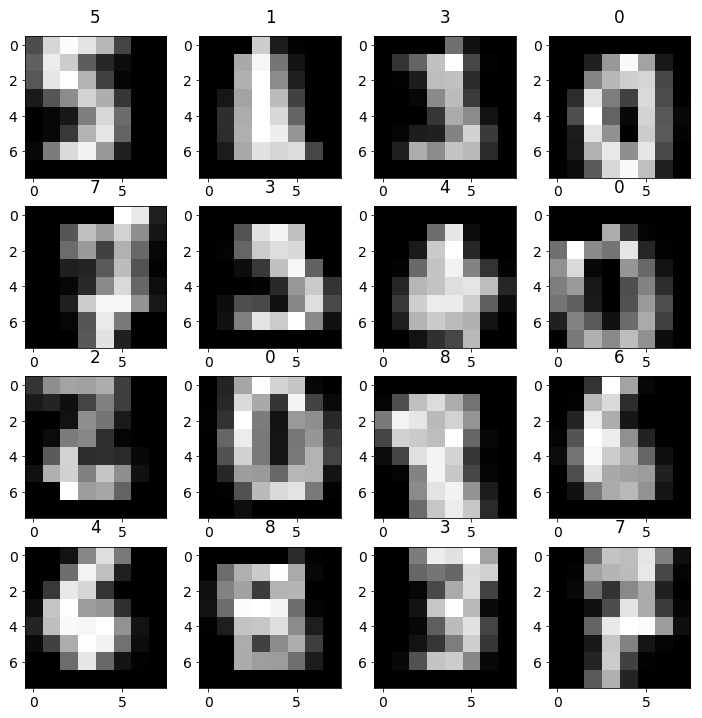

In [70]:
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs[i,:,:,0], cmap='gray')
    plt.title(np.argmax(labels[i]))

As you can see the digits are deformed, due to the very low resolution of the images. Will this help our network or confuse it? Let's find out!

We will need a model that can deal with a tensor input since the images are now tensors of order 4. Luckily, it is effortless to adapt our base model to have a `Flatten` layer as input:

In [71]:
from tensorflow.keras.layers import Flatten

In [72]:
def tensor_model():
    model = Sequential()
    model.add(Flatten(input_shape=(8, 8, 1)))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile('adam', 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

We also need to define a new `repeat_train_generator` function that allows training a model from a generator. We can take the original `repeat_train` function and modify it. We will follow the same procedure used in []() with two difference:


1. We'll define a generator that yields batches from `X_train_t` using the image data generator


2. We'll replace the `.fit` function:
```python
h = model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              verbose=verbose,
              batch_size=batch_size,
              epochs=epochs)
```
with the `.fit_generator` function:
```python
h = model.fit_generator(train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=(X_test_t, y_test),
        verbose=verbose)
```



Notice that, since we are now feeding variations of the data in the train set the definition of an _epoch_ becomes blurry. When does an epoch terminate if we flow random variations of the training data? The `model.fit_generator` function allows us to define how many `steps_per_epoch` we want. We will use the value of 5, with a `batch_size` of 256 like in most of the examples above.

In [73]:
def repeat_train_generator(model_fn, repeats=3,
                           epochs=40, verbose=0,
                           steps_per_epoch=5,
                           batch_size=256):
    """
    Repeatedly train a model on (X_train, y_train),
    averaging the histories using a generator.
    
    Parameters
    ----------
    model_fn : a function with no parameters
        Function that returns a Keras model

    repeats : int, (default=3)
        Number of times the training is repeated
    
    epochs : int, (default=40)
        Number of epochs for each training run
    
    verbose : int, (default=0)
        Verbose option for the `model.fit` function
        
    steps_per_epoch : int, (default=5)
        Steps_per_epoch for the `model.fit` function 
    
    batch_size : int, (default=256)
        Batch size for the `model.fit` function
        
    Returns
    -------
    mean, std : np.array, shape: (epochs, 2)
        mean : array contains the accuracy
        and validation accuracy history averaged
        over the different training runs
        std : array contains the standard deviation
        over the different training runs of
        accuracy and validation accuracy history
    """
    # generator that flows batches from X_train_t
    train_gen = digit_idg.flow(X_train_t, y=y_train,
                               batch_size=batch_size)
    
    histories = []
    
    # repeat model definition and training
    for repeat in range(repeats):
        K.clear_session()
        model = model_fn()
        
        # to train with a generator use .fit_generator()
        h = model.fit_generator(train_gen,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=(X_test_t, y_test),
            verbose=verbose)

        # append accuracy and val accuracy to list
        histories.append([h.history['accuracy'],
                          h.history['val_accuracy']])
        print(repeat, end=" ")
        
    histories = np.array(histories)
    print()
    
    # calculate mean and std across repeats:
    mean = histories.mean(axis=0)
    std = histories.std(axis=0)
    return mean, std

Once the function is defined, we can train it as usual:

In [74]:
(m_train_gen, m_test_gen), (s_train_gen, s_test_gen) = \
    repeat_train_generator(tensor_model)

0 1 2 


And compare the results with our base model:

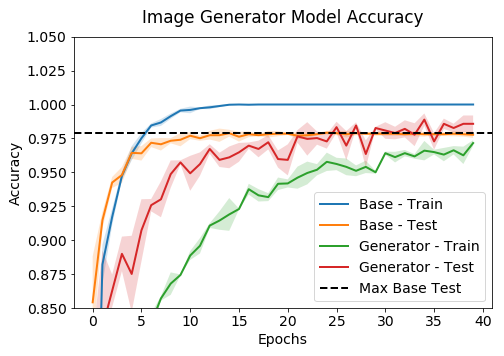

In [75]:
plot_mean_std(m_train_base, s_train_base)
plot_mean_std(m_test_base, s_test_base)

plot_mean_std(m_train_gen, s_train_gen)
plot_mean_std(m_test_gen, s_test_gen)

plt.axhline(m_test_base.max(),
            linestyle='dashed',
            color='black')

plt.title("Image Generator Model Accuracy")
plt.legend(['Base - Train', 'Base - Test',
            'Generator - Train', 'Generator - Test',
            'Max Base Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.05);

As you can see, the Data Augmentation process improved the performance of the model on our test set. Feeding variations of the input data as training, we have made the model more resilient to changes in the input features.

## Tensorflow Data API

Tensorflow 2.0 rationalized the data ingestion process in the `tf.data` module. This is a very powerful module, well described in the [documentation](https://www.tensorflow.org/alpha/tutorials/load_data/images), and it can be used to build custom imput data generators from any sorts of files and filesystems. Let's take a quick look at how to do it. Let's import Tensorflow:

In [76]:
import tensorflow as tf

We will use the `Dataset` class to flow images from the `(X_train_t, y_train)` tuple directly. We start with creating a Dataset instance using the `from_tensor_slices` method:

In [77]:
ds = tf.data.Dataset.from_tensor_slices(
    (X_train_t, y_train))

Let's print it out to check what it is:

In [78]:
ds

<TensorSliceDataset shapes: ((8, 8, 1), (10,)), types: (tf.float64, tf.float32)>

`ds` is an instance of `TensorSliceDataset`. As you can see it knows the shape and type of our data but it does not contain any data. This is basically a generator pointing to the location of the data. Datasets can be created from a variety of sources including:
- Text files: `tf.data.TextLineDataset`
- TFRecords: `tf.data.TFRecordDataset`
- Lists, Tuples, Numpy Arrays & Pandas Dataframes: `tf.data.Dataset.from_tensor_slices`
- CSV files: `tf.data.experimental.CsvDataset`
and they can point to filesystems with Gigabytes or even Terabytes of data. This allows us to scale out to large datasets very easily.

We can map functions to the elements of a dataset with the `.map` method. For example, let's apply here a function that rescales the pixel values to the interval [-1, 1]. Notice that since the dataset will return a tuple of (images, labels), our function needs to be aware of the presence of the label:

In [79]:
def rescale_pixels(image, label):
    return (2 * image) - 1, label

Next we tell the dataset to apply the rescale function to every image when it's loaded, as well as to shuffle the images, repeat the dataset indefinitely and return batches of size 32:

In [80]:
batch_size = 32

In [81]:
ds = ds.map(rescale_pixels)
ds = ds.shuffle(buffer_size=2000)
ds = ds.repeat()
ds = ds.batch(batch_size)

In [82]:
ds

<BatchDataset shapes: ((None, 8, 8, 1), (None, 10)), types: (tf.float64, tf.float32)>

`ds` is now an instance of `BatchDataset`. Let's get a batch from it:

In [83]:
for images, labels in ds.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    print("Images minimum value:", images.numpy().min())
    print("Images maximum value:", images.numpy().max())

Images batch shape: (32, 8, 8, 1)
Labels batch shape: (32, 10)
Images minimum value: -1.0
Images maximum value: 1.0


As you can see the `ds.take` function returns an iterator that generates batches with the correct shape and the rescaled values. We can fit a model on this dataset by simply calling `model.fit`:

In [84]:
model = tensor_model()
model.fit(ds,
          steps_per_epoch=len(X_train_t)//batch_size,
          epochs=2
         )

Epoch 1/2
39/39 [==============================] - 1s 23ms/step - loss: 0.6136 - accuracy: 0.8125
Epoch 2/2
39/39 [==============================] - 0s 6ms/step - loss: 0.0924 - accuracy: 0.9720


This method can be applied to very large datasets. Take a look at [this section of the Tensorflow Documentation](https://www.tensorflow.org/alpha/guide/data_performance) for tips on how to improve the performance of a data ingestion pipeline.

## Hyperparameter optimization

One final note on hyper-parameter optimization. Neural Network models have a lot of hyper-parameters. These are things like:
- model architecture
    - number of layers
    - type of layers
    - number of nodes
    - activation functions
    - ...
- optimizer parameters
    - optimizer type
    - learning rate
    - momentum
    - ...
- training parameters
    - batch size
    - learning rate scheduling
    - number of epochs
    - ...
These parameters are called **Hyper**-parameters because they define the training experiment and the model is not allowed to change them while training. That said, they turn out to be important in determining the success of a model in solving a particular problem.

The topic of hyper-parameter tuning is vast, and we don't have space to cover it in detail. However, the task is now simplified thanks to the introduction of a Hyperparameter tuning tool in Tensorboard. Let's see a quick example of how it works.

### Hyper-parameter tuning in Tensorboard

This section follows parts of the [Tensorboard documentation](https://www.tensorflow.org/tensorboard/r2/hyperparameter_tuning_with_hparams).


Let's star by modifying the model generating function, allowing it to accept a dictionary of hyper-parameters:

In [85]:
def tensor_model(hparams):
    model = Sequential()
    model.add(Flatten(input_shape=(8, 8, 1)))
    
    for i in range(hparams['n_layers']):
        model.add(Dense(hparams['n_units'],
                        activation=hparams['activation']))
        model.add(Dropout(hparams['dropout']))

    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer=hparams['optimizer'],
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Next we create a `train_test_hp` function that will create the model, train it, evaluate it and return the accuracy. This function too may take hyper-parameters like the batch_size, the number of epochs, and so on.

In [86]:
def train_test_hp(hparams):
    model = tensor_model(hparams)
    
    model.fit(X_train_t, y_train,
              epochs=hparams['epochs'],
              batch_size=hparams['batch_size'],
              verbose=0)
    
    _, accuracy = model.evaluate(X_test_t, y_test,
                                 verbose=0)
    return accuracy

Let's test that our function works with a set of hyper-parameters:

In [87]:
hp_example = {
    'n_layers': 3,
    'n_units': 1024,
    'activation': 'relu',
    'optimizer': 'adam',
    'epochs': 1,
    'dropout': 0.0,
    'batch_size': 32
}

In [88]:
train_test_hp(hp_example)

0.94814813

Great! Now that we know our function works, we will define a helper function to log the training runs in Tensorboard. The code for this function is a little complicated, but you can use it as is without having to worry too much about it. We also need to import a couple of additional functions:

In [89]:
from tensorboard.plugins.hparams import api_pb2
from tensorboard.plugins.hparams import summary as hparams_summary

In [90]:
def run_eperiment(run_dir, hparams):
    writer = tf.summary.create_file_writer(run_dir)
    summary_start = hparams_summary.session_start_pb(
        hparams=hparams)

    with writer.as_default():
        accuracy = train_test_hp(hparams)
        summary_end = hparams_summary.session_end_pb(
            api_pb2.STATUS_SUCCESS)
          
        tf.summary.scalar('accuracy',
                          accuracy,
                          step=1,
                          description="The accuracy")
        tf.summary.import_event(
            tf.compat.v1.Event(summary=summary_start)
            .SerializeToString())
        tf.summary.import_event(
            tf.compat.v1.Event(summary=summary_end)
            .SerializeToString())
    return accuracy

Let's run a a few experiments and visualize the results.

#### Grid Search and Random Search

There are various strategies to search for the optimal hyper-parameter combination. The two most common strategies are:

- Grid Search: brute force search through all possible combinations of hyper-parameters
- Random Search: try random combinations of hyperparameters

In practice, Random Search is much more effective when dealing with large spaces and many hyper-parameters.

Scikit-Learn offers two very convenient classes for hyper-parameter search: `ParameterGrid` and `ParameterSampler`. They implement grid search and random search respectively. Let's import them:

In [91]:
from sklearn.model_selection import ParameterGrid, ParameterSampler

Let's also import a couple of random distributions from Scipy:

In [92]:
from scipy.stats.distributions import uniform, randint

and let's define a larger set of parameters to try:

In [93]:
hp_ranges = {
    'n_layers': randint(1, 4),
    'n_units': [64, 256, 1024],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [5],
    'dropout': uniform(loc=0.0, scale=0.6),
    'batch_size': [16, 32, 64]
}

Let's also define a small helper function to print the hyper-parameters:

In [94]:
def print_hparams(d):
    for k, v in d.items():
        if type(v) == np.float64:
            print('  {:<20}: {:0.3}'.format(k, v))
        else:
            print('  {:<20}: {}'.format(k, v))

Now let's generate a couple of example experiments with the `ParameterSampler`:

In [95]:
hp_sets = ParameterSampler(hp_ranges, n_iter=2, random_state=1)

for i, hp_set in enumerate(hp_sets):
    print()
    print("Hyperparameter Set {}:".format(i))
    print_hparams(hp_set)


Hyperparameter Set 0:
  activation          : tanh
  batch_size          : 16
  dropout             : 0.56
  epochs              : 5
  n_layers            : 2
  n_units             : 256
  optimizer           : rmsprop

Hyperparameter Set 1:
  activation          : relu
  batch_size          : 16
  dropout             : 0.238
  epochs              : 5
  n_layers            : 2
  n_units             : 64
  optimizer           : adam


As you can see, the `ParameterSampler` samples from the possible combinations of parameters. Let's run a few experiments and check the results:

In [96]:
import os

In [97]:
experiment_num = 0
log_dir = '/tmp/ztdl/tensorboard/'

for hparams in ParameterSampler(hp_ranges, n_iter=10, random_state=0):
    print('Experiment', experiment_num + 1)
    print_hparams(hparams)
    
    run_name = "run-{:d}".format(experiment_num)
    accuracy = run_eperiment(os.path.join(log_dir, run_name), hparams)

    print("Accuracy: {:0.4}".format(accuracy))
    print()
    
    experiment_num += 1

Experiment 1
  activation          : relu
  batch_size          : 32
  dropout             : 0.507
  epochs              : 5
  n_layers            : 2
  n_units             : 256
  optimizer           : adam
Accuracy: 0.95

Experiment 2
  activation          : relu
  batch_size          : 64
  dropout             : 0.034
  epochs              : 5
  n_layers            : 1
  n_units             : 1024
  optimizer           : rmsprop
Accuracy: 0.9556

Experiment 3
  activation          : relu
  batch_size          : 64
  dropout             : 0.341
  epochs              : 5
  n_layers            : 2
  n_units             : 256
  optimizer           : rmsprop
Accuracy: 0.9463

Experiment 4
  activation          : relu
  batch_size          : 32
  dropout             : 0.389
  epochs              : 5
  n_layers            : 1
  n_units             : 256
  optimizer           : adam
Accuracy: 0.9407

Experiment 5
  activation          : tanh
  batch_size          : 16
  dropout             

We can now visualize our runs by starting tensorboard using the Tensoboard Notebook Extension. Just uncomment the next two cells and you should see a window like this appear:

![tensorboard_hparams.png](./assets/tensorboard_hparams.png)

You can also run tensorboard in a separate terminal with the command:

```bash
tensorboard --logdir /tmp/ztdl/tensorboard/
```
and then open another browser window at address: http://localhost:6006.

In [98]:
# %load_ext tensorboard.notebook

In [99]:
# %tensorboard --logdir {log_dir}

### Weights and Biases

[Weights and Biases](https://www.wandb.com/) allows you to store parameters and associated performance of thousands of runs. You can then quickly search for patterns and regions of interest in the Hyperparameter space.

### Hyperopt and Hyperas

[Hyperopt](https://github.com/hyperopt/hyperopt) is a Python library that can perform generalized hyper-parameter tuning using a technique called Bayesian Optimization.

[Hyperas](https://github.com/maxpumperla/hyperas) is a library that connects Hyperopt and Keras, making it easy to run parallel trainings of a keras model with variations in the values of the hyper-parameters.

### Cloud based tools

[SigOpt](https://sigopt.com/) is a cloud based implementation of Bayesian hyperparameter search.

[AWS SageMaker](https://aws.amazon.com/sagemaker/) and [Google Cloud ML](https://cloud.google.com/ml-engine/docs/tensorflow/hyperparameter-tuning-overview) offer options for spawning parallel training experiments with different hyper-parameter combinations.

[Determined.ai](https://determined.ai/) and [Pipeline.ai](https://pipeline.ai/) also offer this feature as part of their cloud training platform.

## Exercises

### Exercise 1

This is a long and complex exercise, that should give you an idea of a real world scenario. Feel free to look at the solution if you feel lost. Also, feel free to run this on a GPU.

First of all download and unpack the male/female pictures from [here](https://www.zerotodeeplearning.com/media/z2dl/45bzty/male_female.tgz) into a subfolder of the `../data` folder. These images and labels were obtained from [Crowdflower](https://www.figure-eight.com/data-for-everyone/).

Your goal is to build an image classifier that will recognize the gender of a person from pictures.

- Have a look at the directory structure and inspect a couple of pictures
- Design a model that will take a color image of size 64x64 as input and return a binary output (female=0/male=1)
- Feel free to introduce any regularization technique in your model (Dropout, Batch Normalization, Weight Regularization)
- Compile your model with an optimizer of your choice
- Using `ImageDataGenerator`, define a train generator that will augment your images with some geometric transformations. Feel free to choose the parameters that make sense to you.
- Define also a test generator, whose only purpose is to rescale the pixels by 1./255
- Use the function `flow_from_directory` to generate batches from the train and test folders. Make sure you set the `target_size` to 64x64.
- Use the `model.fit_generator` function to fit the model on the batches generated from the `ImageDataGenerator`. Since you are streaming and augmenting the data in real-time, you will have to decide how many batches make an epoch and how many epochs you want to run
- Train your model (you should get to at least 85% accuracy)
- Once you are satisfied with your training, check a few of the misclassified pictures.
- Read about [human bias in Machine Learning datasets](https://www.technologyreview.com/s/608986/forget-killer-robotsbias-is-the-real-ai-danger/)